In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from wordcloud import WordCloud # a neat way to visualize most common words in our text

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
import scipy.cluster.hierarchy as shc

# Using RFM and Clustering Algorithms for Customer Segmentation
### DTSA 5510 Final Project | by: Joseph Bae
----------------------
# Table of Contents
* [Project Background](#Project-Background-)
* [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis)
* [RFM Segmentation with Quartiles](#RFM-Segmentation-with-Quartiles)
* [RFM Segmentation with K-Means Clustering](#RFM-Segmentation-with-K-Means-Clustering)
* [RFM Segmentation with Hierarchical Clustering](#RFM-Segmentation-with-Hierarchical-Clustering)
* [Model Comparison: Agglomerative with n_clusters=9](#Model-Comparison:-Agglomerative-clustering-with-n_clusters=9)
* [Conclusion: Which model is best?](#Conclusion:-Which-model-is-best?)
* [References](#References-)
----------------------
### Project Background <a name="project_background"></a>
Any business looking to understand their customers and maximize their revenue should be doing customer segmentation. It is the process of dividing up their customer base into groups based on purchase behavior, and the business can target these groups with defined marketing promotions, and tailored products specially made to encourage each group to purchase. This is much more effective than, say, targeting all of their customers with the same deals, because that doesn't take into account individuals' purchase habits such as how often they want to shop, how much they want to pay, and whether they are active at this moment in time.

A popular framework for customer segmentation is RFM, which stands for Recency, Frequency, Monetary. Customers are given a value for each of these 3 dimensions, and together these define their RFM segment. 
* Recency - how long has it been since their last purchase
* Frequency - how often do they make a purchase (e.g., monthly or annually)
* Monetary - how much do they spend on average

A typical methodology is to divide each of R, F, and M values into quartiles, which means there will be 4x4x4 = 64 max possible RFM segments produced. We will explore the output of this kind of segmentation and its drawbacks. Clustering can also be utilized, instead of quartiles, to group similar customers together using RFM values. This project will explore the process of producing these customer segments using quartiles vs. k-means clustering vs. hierarchical clustering. Each method will be compared in terms of how useful they'd be to a company looking to create a marketing strategy.

### Data
The data we'll be using is the 'Online Retail' data set from the UCI ML Repository$^{1}$, which is a transnational dataset consisting of all transactions between 2010-2011 for a UK-based online retailer. https://archive.ics.uci.edu/dataset/352/online+retail

----------------------
# Exploratory Data Analysis

In [2]:
data = pd.read_excel('online_retail.xlsx')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


The dataset has 541,909 records and 8 features. By inspecting the first few records, we can see each that record clearly represents a customer order, with the order details including item purchased, quantity, date, price, customer ID, and country. With this data, we have enough information to determine each customer's RFM segment based on their recorded transactions.

## Column: InvoiceNo
Definition from UCI Repository: a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

In [5]:
data['InvoiceNo'].value_counts()

InvoiceNo
573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
581483        1
581566        1
C581499       1
C536383       1
C536379       1
Name: count, Length: 25900, dtype: int64

In [6]:
data[data['InvoiceNo'] == 573585] # InvoiceNo with most records

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
430237,573585,11001,ASSTD DESIGN RACING CAR PEN,2,2011-10-31 14:41:00,3.29,NaN,United Kingdom
430238,573585,15036,ASSORTED COLOURS SILK FAN,15,2011-10-31 14:41:00,1.63,NaN,United Kingdom
430239,573585,15039,SANDALWOOD FAN,15,2011-10-31 14:41:00,1.63,NaN,United Kingdom
430240,573585,15056BL,EDWARDIAN PARASOL BLACK,1,2011-10-31 14:41:00,12.46,NaN,United Kingdom
430241,573585,15056N,EDWARDIAN PARASOL NATURAL,1,2011-10-31 14:41:00,12.46,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
431346,573585,90209C,PINK ENAMEL+GLASS HAIR COMB,3,2011-10-31 14:41:00,2.07,NaN,United Kingdom
431347,573585,90214S,"LETTER ""S"" BLING KEY RING",1,2011-10-31 14:41:00,0.83,NaN,United Kingdom
431348,573585,DOT,DOTCOM POSTAGE,1,2011-10-31 14:41:00,2019.05,NaN,United Kingdom
431349,573585,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2011-10-31 14:41:00,16.67,NaN,United Kingdom


There are 25,900 unique InvoiceNo's, and it looks like multiple records can have the same InvoiceNo when they're a part of the same transaction. The largest transaction has 1114 records! <br>
When counting purchases per customer later, I should consider multiple records with one InvoiceNo as one purchase.

## Column: StockCode
Definition from UCI Repository: a 5-digit integral number uniquely assigned to each distinct product.

<Axes: title={'center': 'Top 20 StockCode by Rowcount'}, xlabel='StockCode'>

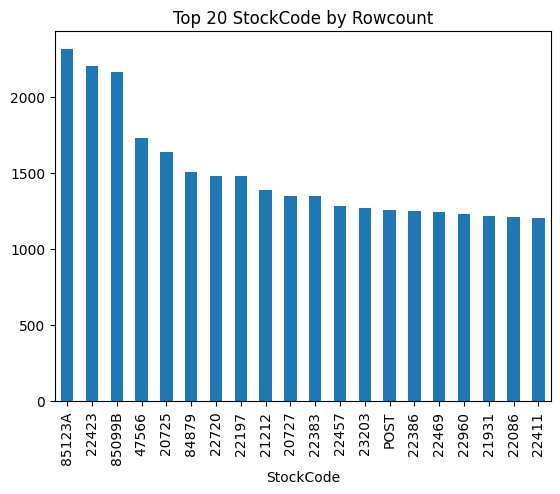

In [7]:
data['StockCode'].value_counts().head(20).plot(kind='bar', title='Top 20 StockCode by Rowcount')

In [8]:
data[data['StockCode'] == '85123A']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850.0,United Kingdom
66,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:32:00,2.55,17850.0,United Kingdom
220,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2010-12-01 10:19:00,2.55,17511.0,United Kingdom
262,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2010-12-01 10:39:00,2.55,13408.0,United Kingdom
...,...,...,...,...,...,...,...,...
539342,581439,85123A,CREAM HANGING HEART T-LIGHT HOLDER,1,2011-12-08 16:30:00,5.79,NaN,United Kingdom
539979,581452,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2011-12-08 18:03:00,2.55,17675.0,United Kingdom
540217,581472,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2011-12-08 19:55:00,2.95,15796.0,United Kingdom
540837,581492,85123A,CREAM HANGING HEART T-LIGHT HOLDER,3,2011-12-09 10:03:00,5.79,NaN,United Kingdom


StockCode can be used to identify unique products. The dataset then contains 4,070 unique products, and the most popular one was purchased 2,313 times.

## Column: Description
Definition from UCI Repository: product name. We see there are 1,454 data points with null Description. Since they still have a StockCode which also identifies products, I'm choosing to leave these in as they're likely valid entries.

In [9]:
data['Description'].isna().sum()

np.int64(1454)

In [10]:
data[data['Description'].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2011-12-07 18:26:00,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,2011-12-07 18:31:00,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,2011-12-07 18:35:00,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom


In [11]:
data['Description'].value_counts().head(20)

Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
ASSORTED COLOUR BIRD ORNAMENT         1501
SET OF 3 CAKE TINS PANTRY DESIGN      1473
PACK OF 72 RETROSPOT CAKE CASES       1385
LUNCH BAG  BLACK SKULL.               1350
NATURAL SLATE HEART CHALKBOARD        1280
POSTAGE                               1252
JUMBO BAG PINK POLKADOT               1251
HEART OF WICKER SMALL                 1237
JAM MAKING SET WITH JARS              1229
JUMBO STORAGE BAG SUKI                1214
PAPER CHAIN KIT 50'S CHRISTMAS        1210
JUMBO SHOPPER VINTAGE RED PAISLEY     1202
LUNCH BAG CARS BLUE                   1197
LUNCH BAG SPACEBOY DESIGN             1192
JAM MAKING SET PRINTED                1182
Name: count, dtype: int64

In [12]:
all_words = str(data['Description'].values)

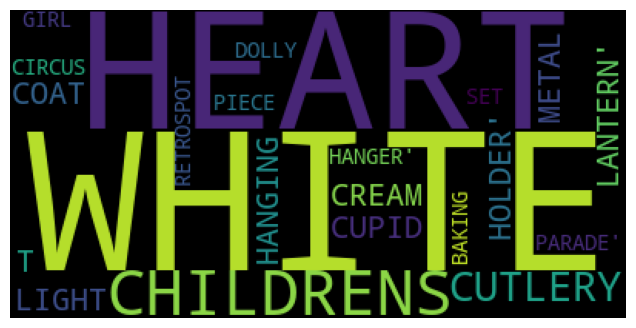

In [13]:
wc = WordCloud().generate(all_words)
plt.figure(figsize=(8,4))
plt.axis("off")
plt.imshow(wc)

The most common words in the Description feature are 'White' and 'Heart', which makes sense since they're in the name of most popular product. Words like "Baking", "Cutlery", "Lantern" obviously describe other products. "Parade" and "Circus" are also part of other product names.

In [14]:
data[data['Description'].astype(str).str.contains("CIRCUS")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
37,536370,22631,CIRCUS PARADE LUNCH BOX,24,2010-12-01 08:45:00,1.95,12583.0,France
42,536370,22540,MINI JIGSAW CIRCUS PARADE,24,2010-12-01 08:45:00,0.42,12583.0,France
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
463,536408,22716,CARD CIRCUS PARADE,12,2010-12-01 11:41:00,0.42,14307.0,United Kingdom
503,536409,22531,MAGIC DRAWING SLATE CIRCUS PARADE,1,2010-12-01 11:45:00,0.42,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541775,581578,23255,CHILDRENS CUTLERY CIRCUS PARADE,12,2011-12-09 12:16:00,4.15,12713.0,Germany
541791,581578,22711,WRAP CIRCUS PARADE,25,2011-12-09 12:16:00,0.42,12713.0,Germany
541894,581587,22631,CIRCUS PARADE LUNCH BOX,12,2011-12-09 12:50:00,1.95,12680.0,France
541895,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-12-09 12:50:00,1.65,12680.0,France


## Column: Quantity
Definition from UCI Repository: the quantities of each product (item) per transaction.

In [15]:
data['Quantity'].dtype

dtype('int64')

<Axes: >

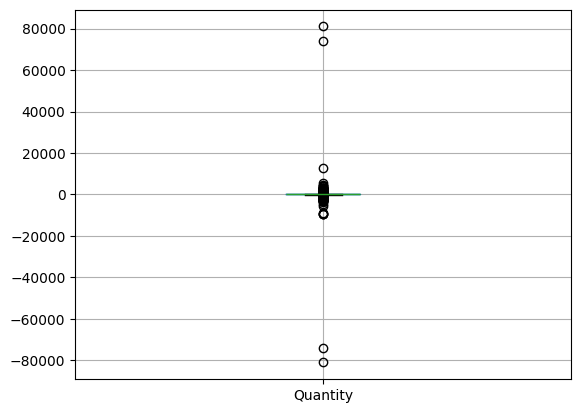

In [16]:
data.boxplot(column='Quantity')

We can see Quantity has a huge range of values, but most are clustered close to zero. There are 2 rows with over 60k quantity, but they were also cancelled later based on the 2 negative entries below -60K.

In [17]:
data[abs(data['Quantity']) > 60000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


In [18]:
user_qty = data.groupby(by='CustomerID', as_index=False).sum('Quantity').sort_values(by='Quantity')
user_qty

,CustomerID,Quantity,UnitPrice
3103,16546.0,-303,53.03
2578,15823.0,-283,85.19
1384,14213.0,-244,24.45
3245,16742.0,-189,472.65
2892,16252.0,-158,67.10
...,...,...,...
4233,18102.0,64122,5159.73
3758,17450.0,69029,3320.09
1895,14911.0,77180,31060.66
55,12415.0,77242,2499.82


In [19]:
user_qty[user_qty['Quantity'] < 0].shape[0]

40

Quantity has all numeric values but is negative for cancelled orders. Total quantity per user ranges from -303 to 196,719. There are 40 users that have a negative total order quantity, which is not practically possible and might be some data issue. Let's remove these 40 customers' records from the dataset so they don't cause issues with the model.

In [20]:
neg_users = user_qty[user_qty['Quantity'] < 0]['CustomerID'] # all customerIDs with a negative total order quantity
data = data[data['CustomerID'].isin(neg_users) == False] # removes records of customerIDs found in neg_users
data.shape

(541718, 8)

There are 541,718 records remaining in our data which is 99.9% of original, so we have lost almost no information by dropping the records.

## Column: InvoiceDate
Definition from UCI Repository: the day and time when each transaction was generated

In [21]:
data['InvoiceDate'].dtype

dtype('<M8[ns]')

We see the datatype is <M8[ns] which is equivalent to timestamp. Let's plot the distribution of records by day to get a sense of scale and timeframe of our dataset.

In [22]:
date_agg = data.groupby(by=data['InvoiceDate'].dt.floor('d')).agg({'InvoiceNo':'count'})
date_agg

,InvoiceNo
InvoiceDate,
2010-12-01,3101
2010-12-02,2088
2010-12-03,2196
2010-12-05,2725
2010-12-06,3877
...,...
2011-12-05,5330
2011-12-06,3365
2011-12-07,2438


<Axes: title={'center': 'Count of Invoices by Date'}, xlabel='InvoiceDate'>

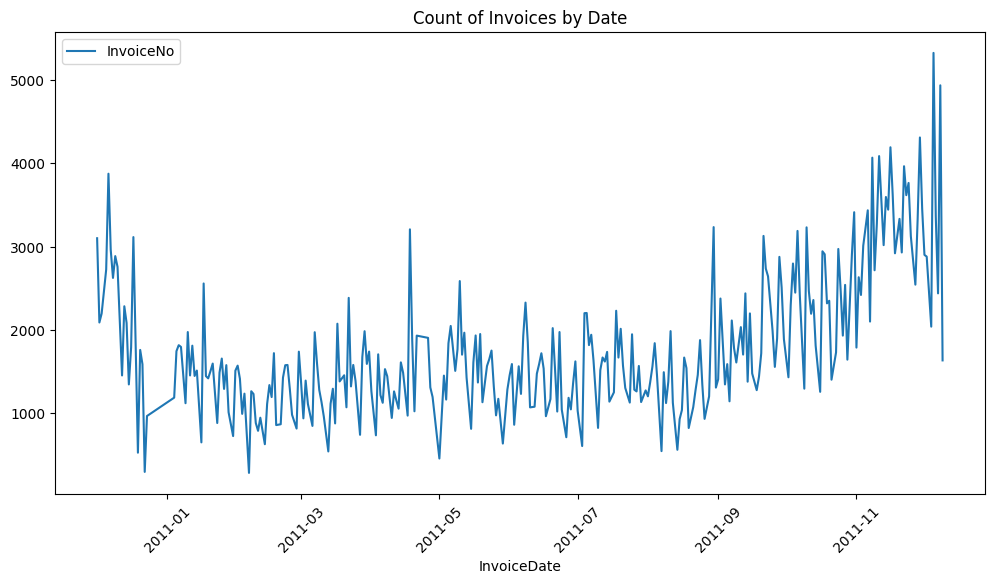

In [23]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
plt.title('Count of Invoices by Date')
sns.lineplot(date_agg)

It looks like there is a small data gap between 2010-Dec and 2011-Jan, and another tiny one before 2011-May. Otherwise the data looks well distributed across the total date range. The counts peak near the end of 2011, which makes sense given its the holiday period when many people are shopping.

## Column: UnitPrice
Definition from UCI Repository: product price per unit.

In [24]:
data['UnitPrice'].dtype

dtype('float64')

In [25]:
data['UnitPrice'].describe()

count    541718.000000
mean          4.591659
std          96.548583
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

<Axes: >

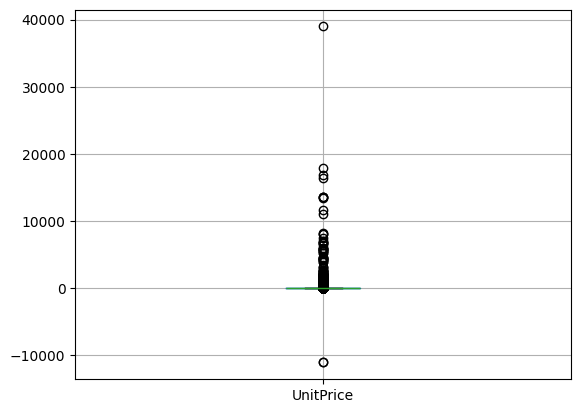

In [26]:
data.boxplot(column='UnitPrice')

The mean of UnitPrice is 4.59, but there are some very high values in the thousands, and also negative values that don't seem like valid price values. Let's see what products are responsible for these values.

In [27]:
data[(data['UnitPrice'] > 500) | (data['UnitPrice'] < 0)]['Description'].value_counts()

Description
DOTCOM POSTAGE                    105
Manual                             92
AMAZON FEE                         31
CRUK Commission                     7
POSTAGE                             6
Bank Charges                        4
Adjust bad debt                     3
PICNIC BASKET WICKER 60 PIECES      2
Discount                            1
SAMPLES                             1
Name: count, dtype: int64

We need to remove all records of fees, postage, and other records that aren't actually purchases, because their values heavily skew our dataset which will negatively affect our model performance.

In [28]:
to_remove = data[(data['UnitPrice'] > 500) | (data['UnitPrice'] < 0)]['Description'].value_counts().keys()
to_remove = to_remove.drop('PICNIC BASKET WICKER 60 PIECES') # this looks like an actual product with high UnitPrice
data = data[data['Description'].isin(to_remove) == False] # remove all records with a Description in to_remove

In [29]:
data[(data['UnitPrice'] > 500) | (data['UnitPrice'] < 0)]['Description'].value_counts()

Description
PICNIC BASKET WICKER 60 PIECES    2
Name: count, dtype: int64

In [30]:
data.shape

(538972, 8)

We removed about 2.7K records (0.5% of total) that were for fees, adjustments, and other things that weren't actual purchases.

In [31]:
data['UnitPrice'].describe()

count    538972.000000
mean          3.281831
std           4.557691
min           0.000000
25%           1.250000
50%           2.080000
75%           4.130000
max         649.500000
Name: UnitPrice, dtype: float64

In [32]:
unitprice_bin = pd.cut(data['UnitPrice'], bins=20)
unitprice_bin.value_counts()

UnitPrice
(-0.65, 32.475]      538158
(32.475, 64.95]         619
(97.425, 129.9]          72
(64.95, 97.425]          60
(162.375, 194.85]        25
(129.9, 162.375]         13
(194.85, 227.325]        12
(292.275, 324.75]        10
(617.025, 649.5]          2
(259.8, 292.275]          1
(324.75, 357.225]         0
(227.325, 259.8]          0
(357.225, 389.7]          0
(389.7, 422.175]          0
(454.65, 487.125]         0
(422.175, 454.65]         0
(487.125, 519.6]          0
(519.6, 552.075]          0
(552.075, 584.55]         0
(584.55, 617.025]         0
Name: count, dtype: int64

The vast majority of records now are for products with a price between 0 (bin edge is -0.65, but data min is 0) and 32.475 which looks reasonable. There are some products with a high price in the hundreds, but they're rare enough that it shouldn't really affect our models anymore.

## Column: CustomerID
Definition from UCI Repository: a 5-digit integral number uniquely assigned to each customer.

In [33]:
data['CustomerID'].dtype

dtype('float64')

In [34]:
data['CustomerID'].isna().sum()

np.int64(134099)

We have a data quality issue where over 134K records have a NaN customerID, and so will all be grouped together by our models as if it's all from one purchaser. These records will have to be dropped, though it's unfortunate since this is almost 25% of our dataset.

In [35]:
data = data[data['CustomerID'].isna() == False]
data.shape

(404873, 8)

In [36]:
data['CustomerID'] = data['CustomerID'].astype(int) # now without the NaNs we can convert the CustomerID column to int, which it's supposed to be

In [37]:
data['CustomerID'].value_counts()

CustomerID
17841    7971
14911    5898
14096    5095
12748    4623
14606    2778
         ... 
15753       1
17291       1
13120       1
15118       1
13256       1
Name: count, Length: 4331, dtype: int64

We can see from value_counts() that there's 4,331 unique customers in our dataset. The entries per customerID ranges from 1 to 7,971 -- the customerIDs with high row counts are likely business/enterprise customers that buy in bulk.

<Axes: title={'center': 'Dist. of Invoice Count per CustomerID'}, xlabel='CustomerID'>

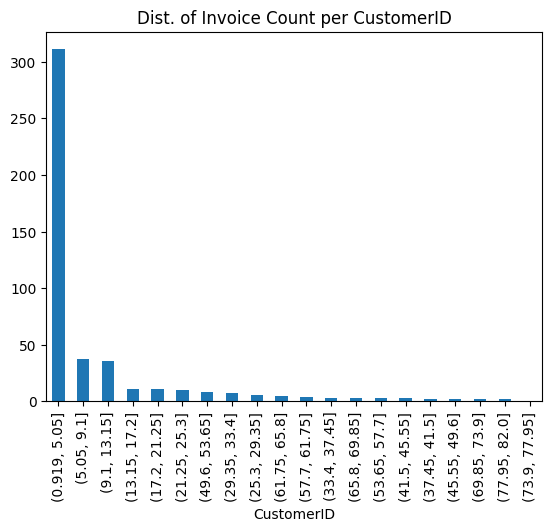

In [38]:
customer_cnt = data.groupby(by='CustomerID', as_index=False).count()
pd.cut(customer_cnt.groupby(by='InvoiceNo').count()['CustomerID'], 20).value_counts().plot(kind='bar', title='Dist. of Invoice Count per CustomerID')

The distribution of invoices per customer is right skewed, and the vast majority of customers have between (0.919, 5.05) purchases. We can consider this the same as 1-5 purchases, as the binning function$^{2}$ adds a small value to either end of the bounds to include the numbers at the edges.

## Column: Country

In [39]:
pd.concat([data['Country'].value_counts(), data['Country'].value_counts(normalize=True)], axis=1, keys=['Count', 'Pct'])

,Count,Pct
Country,,
United Kingdom,361120,0.891934
Germany,9093,0.022459
France,8170,0.020179
EIRE,7479,0.018472
Spain,2468,0.006096
Netherlands,2330,0.005755
Belgium,1971,0.004868
Switzerland,1844,0.004555
Portugal,1436,0.003547


<Axes: xlabel='Country'>

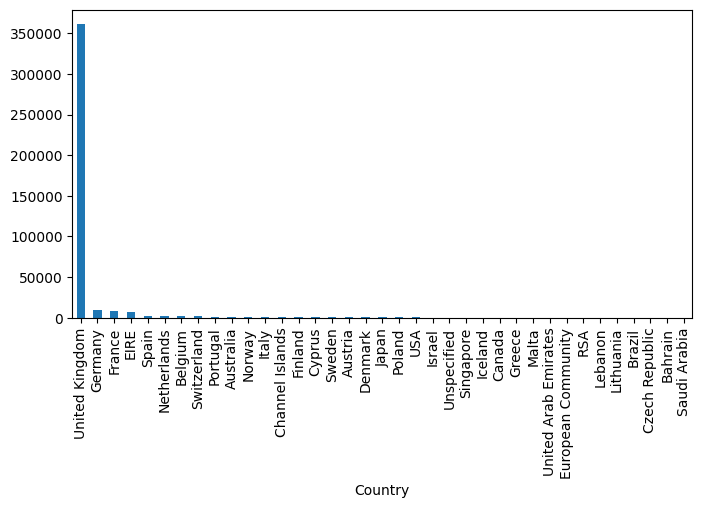

In [40]:
plt.figure(figsize=(8,4))
data['Country'].value_counts().plot(kind='bar')

The vast majority, about 89%, of records have country United Kingdom. Since the dataset is for a UK-based retailer, we can conclude most of this company's sales are within its own country. As far as international sales, it is mostly to European countries, and very few sales are done outside of that. There is a country listed 'EIRE' which is the Gaelic name for Ireland.

## Correlation of Features
The features that are most relevant for RFM, and the ones used for Clustering would be InvoiceDate (to compute recency), Quantity, and UnitPrice. Let's see if there's correlation in these features.

In [41]:
data['InvoiceDateNum'] = pd.to_numeric(data['InvoiceDate']) # numerical representation of date, so we can compute correlation coeff.

<Axes: >

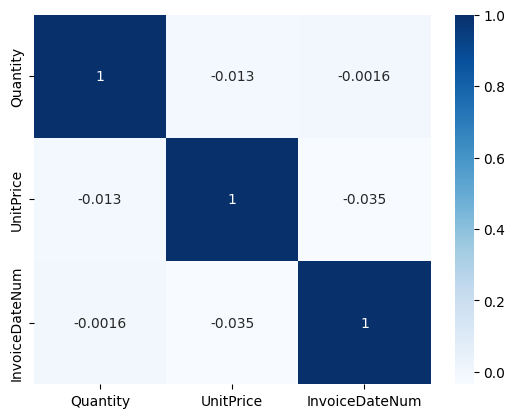

In [42]:
sns.heatmap(data[['Quantity', 'UnitPrice', 'InvoiceDateNum']].corr(), cmap='Blues', annot=True)

We can see the correlation coefficients are all close to zero, meaning that none of these features are correlated with each other.
# RFM Segmentation with Quartiles
There's several methodologies of determining RFM segments from purchase data. Here are the steps we'll use. Since the focus of this project is on ML and not RFM, we won't be doing a comparison of different RFM methods.
1. Consider only orders with a positive quantity, i.e. ignore cancelled orders.
2. Consider only orders in the past 365 days.
3. Compute Recency for each user as the number of days since their latest order, pretending today is Dec 10, 2011 (our dataset spans Dec 01, 2010 to Dec 09, 2011)
4. Compute Frequency as the number of orders made in the past 365 days, again pretending today is Dec 10, 2011.
5. Compute Monetary as the total GBP spent on orders (computed as UnitPrice * Quantity) in the past 365 days.
6. For each of R, F, and M values for each user, compute which Quartile the R/F/M value falls under, out of the total pool of user values.
7. The three quartiles concatenated together is the user RFM segment.

In [43]:
print(data['InvoiceDate'].min())
print(data['InvoiceDate'].max())

2010-12-01 08:26:00
2011-12-09 12:50:00


In [44]:
data['InvoiceDateTrunc'] = data['InvoiceDate'].dt.floor('d') # truncates datetime to date
data['InvoiceAgeInDays'] = -(data['InvoiceDateTrunc'] - pd.to_datetime('12/10/2011')).dt.days # number of days since order, if today is 12/10/2011
data['TotalPurchasePrice'] = data['UnitPrice']*data['Quantity']

In [45]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDateNum,InvoiceDateTrunc,InvoiceAgeInDays,TotalPurchasePrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,1291191960000000000,2010-12-01,374,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,1291191960000000000,2010-12-01,374,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,1291191960000000000,2010-12-01,374,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,1291191960000000000,2010-12-01,374,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,1291191960000000000,2010-12-01,374,20.34


In [46]:
data_excl_cancel = data[data['Quantity'] > 0] # for recency only - consider only non-cancelled orders (quantity > 0)

# recency is the minimum number of days since the latest order
cust_recency = data_excl_cancel[['CustomerID', 'InvoiceAgeInDays']].groupby('CustomerID').min().rename({'InvoiceAgeInDays':'Recency_Val'}, axis=1)

# frequency is the number of unique orders made in the past 365 days
cust_frequency = data[['CustomerID', 'InvoiceNo']].groupby('CustomerID').nunique().rename({'InvoiceNo':'Frequency_Val'}, axis=1)

# monetary is the total GBP spent on orders in the past 365 days
cust_monetary = data[['CustomerID', 'TotalPurchasePrice']].groupby('CustomerID').sum().rename({'TotalPurchasePrice':'Monetary_Val'}, axis=1)

In [47]:
cust_recency.head()

,Recency_Val
CustomerID,
12346,326
12347,3
12348,76
12349,19
12350,311


In [48]:
def quartile_bin(df, reverse=False):
    """Returns a series with the quartile for each value. If reverse=True, the quartile labels are reversed"""

    q1 = df.iloc[:,0].quantile(.25)
    q2 = df.iloc[:,0].quantile(.50)
    q3 = df.iloc[:,0].quantile(.75)
    q4 = df.iloc[:,0].quantile(1.0)

    if reverse:
        return pd.cut(df.iloc[:,0], bins=[-float('inf'), q1, q2, q3, q4], labels=[4, 3, 2, 1]) # this is for Recency where we actually want to give low Recency a high score
    else:
        return pd.cut(df.iloc[:,0], bins=[-float('inf'), q1, q2, q3, q4], labels=[1, 2, 3, 4])

In [49]:
cust_recency['Recency_Score'] = quartile_bin(cust_recency, reverse=True)
cust_frequency['Frequency_Score'] = quartile_bin(cust_frequency)
cust_monetary['Monetary_Score'] = quartile_bin(cust_monetary)

cust_rfm = cust_recency.merge(cust_frequency, how='left', left_on='CustomerID', right_on='CustomerID').merge(cust_monetary, how='left', left_on='CustomerID', right_on='CustomerID')
cust_rfm['RFM_Segment'] = cust_rfm['Recency_Score'].astype(str) + cust_rfm['Frequency_Score'].astype(str) + cust_rfm['Monetary_Score'].astype(str)

In [50]:
cust_rfm.head()

,Recency_Val,Recency_Score,Frequency_Val,Frequency_Score,Monetary_Val,Monetary_Score,RFM_Segment
CustomerID,,,,,,,
12346,326,1,2,2,0.00,1,121
12347,3,4,7,4,4310.00,4,444
12348,76,2,4,3,1437.24,3,233
12349,19,3,1,1,1457.55,3,313
12350,311,1,1,1,294.40,1,111


Now that we have the RFM Segments, let's visualize their distribution and think through how a company would utilize this segments.

<Axes: title={'center': 'RFM Segment Counts'}, xlabel='RFM_Segment', ylabel='Count'>

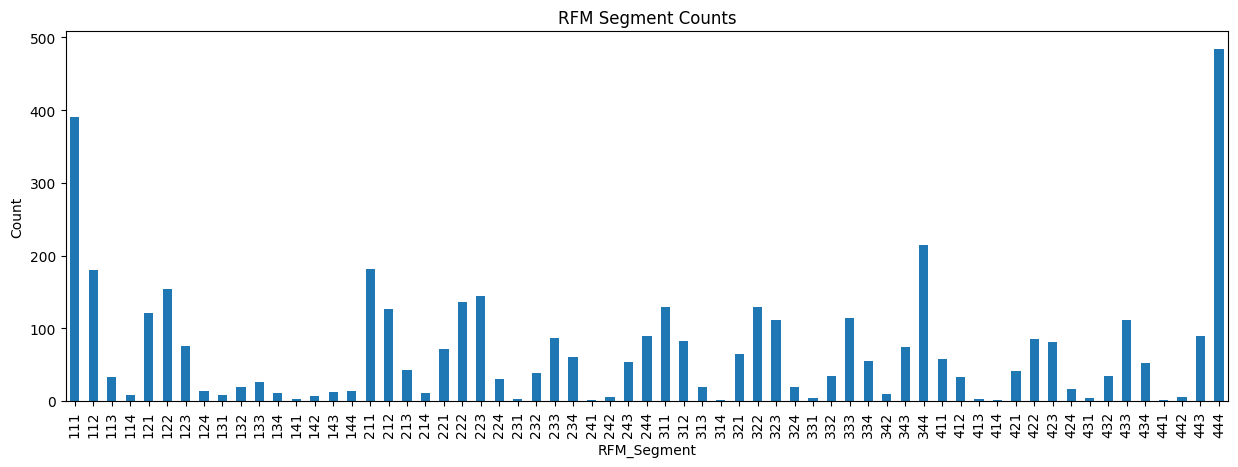

In [51]:
plt.figure().set_figwidth(15)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('RFM Segment Counts')
cust_rfm['RFM_Segment'].value_counts().sort_index().plot(kind='bar')

The first thing to notice is that there are *a lot* of RFM segments, 62 in total. A company will need to invest a lot of time and resources to create 62 different marketing strategies, and many will choose not to do so. Since some segments are smaller, we can group RFM segments together into more meaningful segments. However, going off the quartile scores alone doesn't give us enough information to do that in any decent fashion.

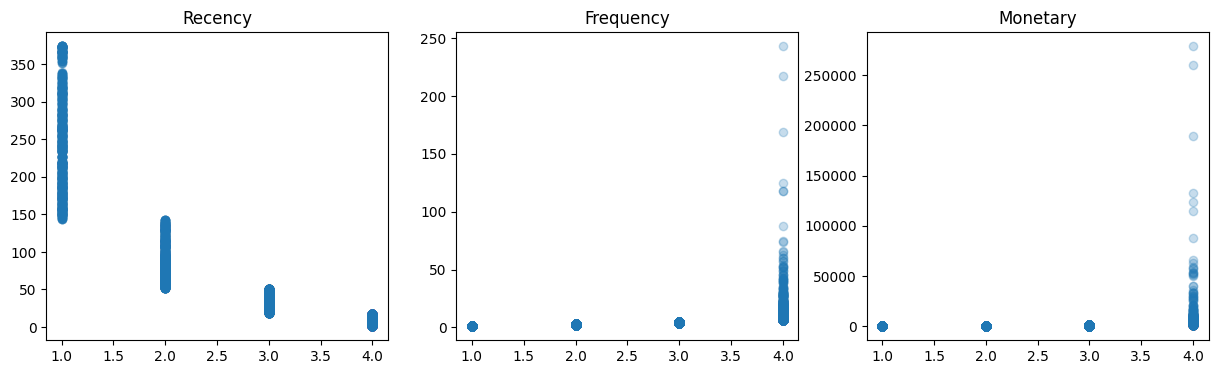

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_figwidth(15)
fig.set_figheight(4)

ax1.set_title('Recency')
ax2.set_title('Frequency')
ax3.set_title('Monetary')

ax1.scatter(cust_rfm['Recency_Score'], cust_rfm['Recency_Val'], alpha=0.25)
ax2.scatter(cust_rfm['Frequency_Score'], cust_rfm['Frequency_Val'], alpha=0.25)
ax3.scatter(cust_rfm['Monetary_Score'], cust_rfm['Monetary_Val'], alpha=0.25)

We can understand the individual RFM scores a bit better by looking at the value range of each quartile for R, F, and M. We can see for Recency there is a logical separation of values, but for Frequency and Monetary, 3 of the quartiles have virtually identical value ranges, and the 4th has a huge range.

This will be a problem for a business because customers will have a Frequency score of 4 whether they purchased 5 orders or 200 orders in the past year. These customers should be scored and marketed to differently, rather than grouped together. Similarly, users have a Monetary score of 4 whether they spent a few thousand, or over 250K. In its current state, we can't do much with the RFM segments to give them more business value without going back and re-doing RFM with different parameters.

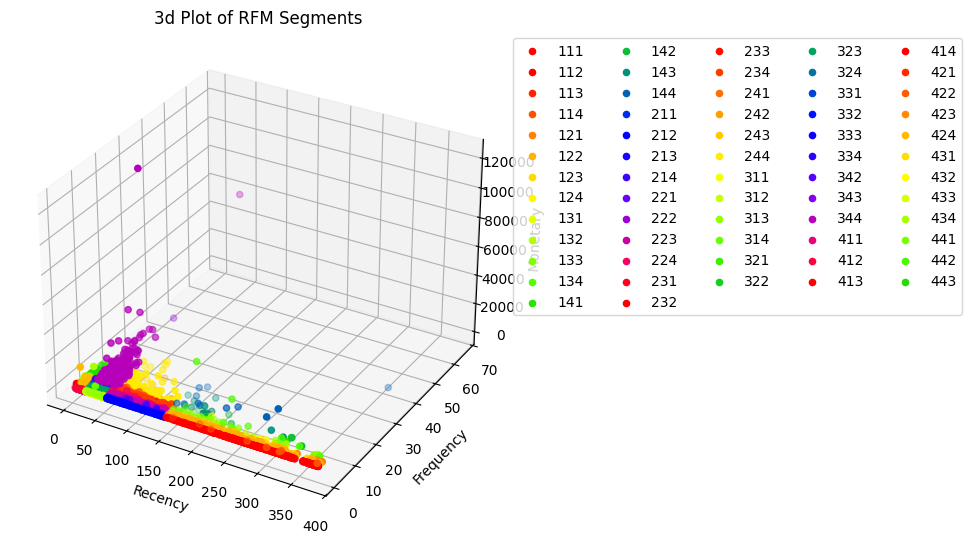

In [53]:
fig = plt.figure()

fig.set_figheight(8)

ax = fig.add_subplot(projection='3d')
ax.set_title('3d Plot of RFM Segments')

for i in range(62):
    rfm = cust_rfm['RFM_Segment'].sort_values().unique()[i]
    
    ax.scatter(cust_rfm[cust_rfm['RFM_Segment'] == rfm]['Recency_Val']
               ,cust_rfm[cust_rfm['RFM_Segment'] == rfm]['Frequency_Val']
               ,cust_rfm[cust_rfm['RFM_Segment'] == rfm]['Monetary_Val']
               ,marker='o', color=cm.prism(i), label=rfm)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.legend(ncol=5, bbox_to_anchor=(1,1));

This is a pretty cool 3D plot of our RFM segments. One thing for certain is that there is an overwhelming amount of segments for a business to choose from. We would definitely need to create groups of these segments by combining similar segments. Another observation is the huge range of values for Frequency and Monetary. It also seems we have a large number of outliers with very high frequency and monetary values.

# RFM Segmentation with K-Means Clustering

K-Means clustering involves partitioning our dataset into *k* clusters, centered around *k* different means, called centroids. This results in every datapoint belonging to the cluster for which its distance to the mean is smallest. We will be performing k-means clustering on our dataset of customers and their R, F, and M values, and interpreting the results.

First we will need to standardize our values by subtracting the mean of those values from each value, and dividing by the standard deviation. The results of this are scaled values that have a mean of zero, and standard deviation of one. By scaling our R, F, and M values by the same standard, our model will treat each of the values equally when computing the clusters. If we did not do scaling, then for example a variable like Monetary, which can range a few hundred thousand units, will have a lot more power in shaping the clusters, than a variable like Recency, which only varies by a few hundred units.

In [54]:
recency_sc = StandardScaler().fit_transform(cust_rfm['Recency_Val'].to_numpy().reshape(-1,1)) # transforms the data to have mean of 0 and sd of 1
frequency_sc = StandardScaler().fit_transform(cust_rfm['Frequency_Val'].to_numpy().reshape(-1,1))
monetary_sc = StandardScaler().fit_transform(cust_rfm['Monetary_Val'].to_numpy().reshape(-1,1))

In [55]:
cust_rfm_scaled = pd.DataFrame({'Recency_Val_Scaled':recency_sc.reshape(-1), 'Frequency_Val_Scaled':frequency_sc.reshape(-1), 'Monetary_Val_Scaled':monetary_sc.reshape(-1)})

In [56]:
cust_rfm_scaled

,Recency_Val_Scaled,Frequency_Val_Scaled,Monetary_Val_Scaled
0,2.327121,-0.331333,-0.230538
1,-0.900071,0.217006,0.288123
2,-0.170706,-0.111997,-0.057582
3,-0.740210,-0.441001,-0.055138
4,2.177252,-0.441001,-0.195111
...,...,...,...
4326,1.847539,-0.441001,-0.208805
4327,0.878382,-0.441001,-0.220813
4328,-0.850115,-0.221665,-0.209287
4329,-0.890080,1.204016,0.020842


One crucial part of K-Means clustering is that we need to specify the number of clusters we want outputted. A popular method of determining what the optimal number of clusters should be, is the Elbow method. This involves computing total WCSS (within cluster sum of squares) of all clusters over a range of K values, where K is the number of clusters. As K increases, the WCSS will decrease, and we want to choose K such that the curve of WCSS starts to become linear, rather than exponential. Such point is referred to as the 'Elbow'.

Note: SKLearn library includes the inertia_ value in the model, which is equivalent to WCSS.

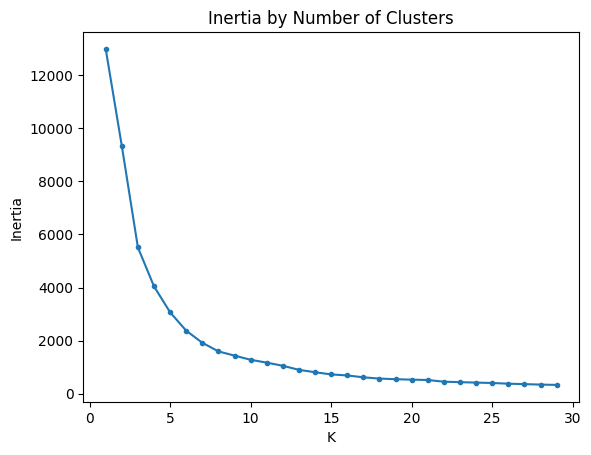

In [61]:
inertia = []
K = range(1,30)

for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(cust_rfm_scaled[['Recency_Val_Scaled', 'Frequency_Val_Scaled', 'Monetary_Val_Scaled']])
    inertia.append(km.inertia_)

plt.title('Inertia by Number of Clusters')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.plot(K, inertia, marker='.')

In [62]:
for i in range(29):
    print(K[i], ":", inertia[i])

1 : 12993.000000000004
2 : 9338.709077169286
3 : 5510.56529435845
4 : 4042.921310186728
5 : 3065.4134908704614
6 : 2373.1596360970398
7 : 1918.2074582785328
8 : 1592.566387840942
9 : 1434.2192409362865
10 : 1276.0490097826464
11 : 1169.6929358319849
12 : 1050.4327176283753
13 : 897.4611640376511
14 : 807.2595032774437
15 : 725.3173999874978
16 : 686.573082923385
17 : 616.2954222752537
18 : 567.9205967124815
19 : 544.6867774297177
20 : 527.8444266946492
21 : 514.5045183942534
22 : 450.91257296934907
23 : 433.2987893361849
24 : 416.75050114672814
25 : 402.193289014713
26 : 375.8646507164444
27 : 358.50135940035784
28 : 342.0517558041592
29 : 329.2172567571039


We can see that the curve starts to flatten out around K=9, where inertia is 1434.22, so we will choose that point as our optimal number of clusters to move forward with.

<Axes: xlabel='KM_Cluster'>

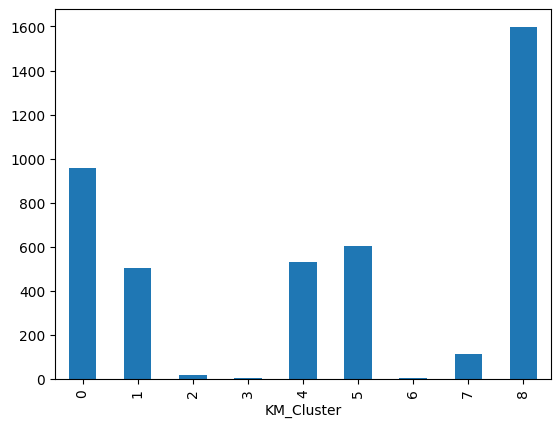

In [63]:
km = KMeans(n_clusters=9, random_state=0).fit(cust_rfm_scaled[['Recency_Val_Scaled', 'Frequency_Val_Scaled', 'Monetary_Val_Scaled']])
cust_rfm_scaled['KM_Cluster'] = km.labels_
cust_rfm_scaled['KM_Cluster'].value_counts().sort_index().plot(kind='bar')

In [64]:
cust_rfm_scaled['KM_Cluster'].value_counts().sort_index()

KM_Cluster
0     957
1     501
2      19
3       3
4     532
5     605
6       3
7     112
8    1599
Name: count, dtype: int64

One thing we immediately notice is that several clusters have only a tiny number of records. These clusters likely contain the outliers we saw previously, which had either very high Frequency or Monetary values compared to all other customers in the data.

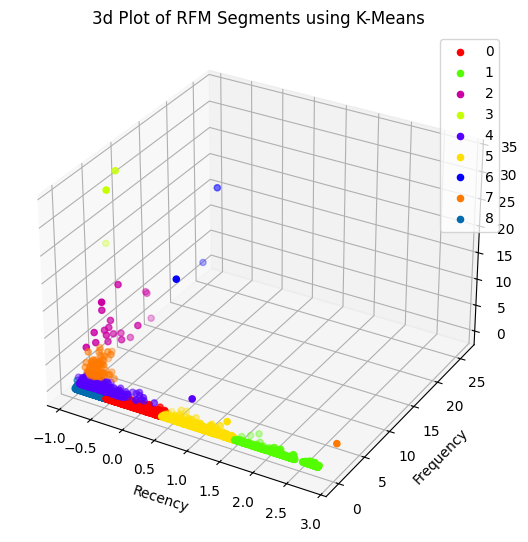

In [69]:
fig = plt.figure()

fig.set_figheight(8)

ax = fig.add_subplot(projection='3d')
ax.set_title('3d Plot of RFM Segments using K-Means')

for i in range(9):
    ax.scatter(cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == i]['Recency_Val_Scaled']
               ,cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == i]['Frequency_Val_Scaled']
               ,cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == i]['Monetary_Val_Scaled']
               ,marker='o', color=cm.prism(9*i), label=i)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.legend();

By viewing the 3D plot, we can see the clustering algorithm did a good job at producing distinct groups of the data. There are a few segments that contain only the outlier customers with high frequency or high monetary values, or both. Realistically, we can probably drop these outlier clusters (2, 3, and 6) because they'll probably be too small to really consider when forming marketing strategy.

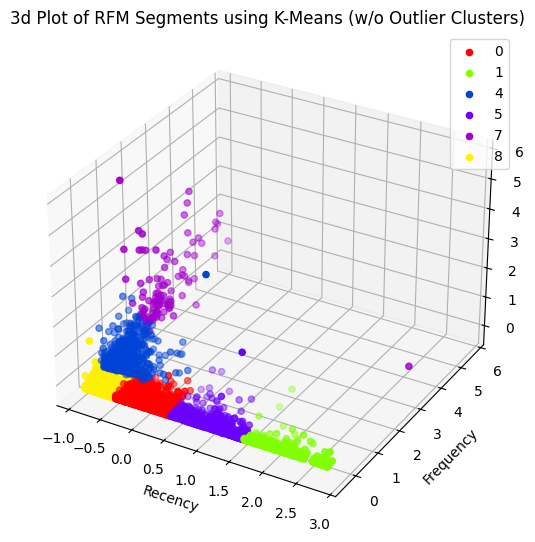

In [66]:
fig = plt.figure()

fig.set_figheight(8)

ax = fig.add_subplot(projection='3d')
ax.set_title('3d Plot of RFM Segments using K-Means (w/o Outlier Clusters)')

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 0]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 0]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 0]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(0), label=0)

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 1]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 1]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 1]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(10), label=1)

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 4]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 4]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 4]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(40), label=4)

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 5]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 5]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 5]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(20), label=5)

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 7]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 7]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 7]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(70), label=7)

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 8]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 8]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['KM_Cluster'] == 8]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(80), label=8)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.legend();

Here we've "zoomed in" the plot by removing clusters 2, 3, 6 which only had outlier customers. We can see the distinct clusters much more clearly now.

<Axes: title={'center': 'Monetary'}, xlabel='KM_Cluster', ylabel='Monetary_Val_Scaled'>

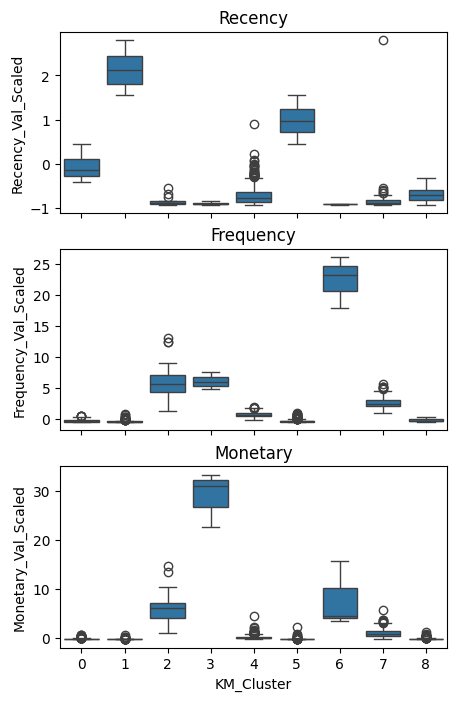

In [67]:
fig, axs = plt.subplots(3, 1, sharex=True)
    
fig.set_figwidth(5)
fig.set_figheight(8)

axs[0].set_title('Recency')
axs[1].set_title('Frequency')
axs[2].set_title('Monetary')

sns.boxplot(x=cust_rfm_scaled['KM_Cluster'], y=cust_rfm_scaled['Recency_Val_Scaled'], ax=axs[0])
sns.boxplot(x=cust_rfm_scaled['KM_Cluster'], y=cust_rfm_scaled['Frequency_Val_Scaled'], ax=axs[1])
sns.boxplot(x=cust_rfm_scaled['KM_Cluster'], y=cust_rfm_scaled['Monetary_Val_Scaled'], ax=axs[2])

Here's another view where we can see that customers with low recency, being the largest group of customers, was divided into several clusters while there's fewer clusters given for customers with high frequency or monetary values, because there's much less of them.

I used the 3d plot and R/F/M boxplots above to give each segment a business "Description" that could be used to define each segment when presenting to a business team. I found that the clusters made it easy to define customers by recency (Recently Active, Inactive, Almost Lapsed, and Lapsed) and also by volume of purchases (1*, 2*, and 3* for most purchases). Clusters 2 3 and 6 contained only outlier customers and I labeled them as such:
| KM_Cluster | Size | Size% | Recency | Frequency | Monetary | Description                        |
|:----------:|:----:|:-----:|:-------:|:---------:|:--------:|------------------------------------|
|      0     |  957 |  22%  |  Medium |    Low    |    Low   | Inactive Customers                 |
|      1     |  501 |  12%  |   High  |    Low    |    Low   | Lapsed Customers                   |
|      2     |  19  |   0%  |   Low   |   Medium  |  Medium  | Outliers (med freq., med monetary) |
|      3     |   3  |   0%  |   Low   |   Medium  |   High   | Outliers (high monetary)           |
|      4     |  532 |  12%  |   Low   |    Low    |    Low   | Recently Active 2* Customers       |
|      5     |  605 |  14%  |   High  |    Low    |    Low   | Almost Lapsed Customers            |
|      6     |   3  |   0%  |   Low   |    High   |  Medium  | Outliers (high frequency)          |
|      7     |  112 |   3%  |   Low   |   Medium  |    Low   | Recently Active 3* Customers       |
|      8     | 1599 |  37%  |   Low   |    Low    |    Low   | Recently Active 1* Customers       |

# RFM Segmentation with Hierarchical Clustering

An alternate approach to clustering is hierarchical, specifically agglomerative. In this approach, clusters are formed in a "bottom-up" (aka agglomerative) fashion, where every data point is put in its own cluster at the beginning. From there, it is grouped with the closest datapoint in Euclidean distance to form a cluster. Then, this too is grouped with the nearest cluster (cluster-to-cluster distances can be computed using several different methods) until every datapoint is contained in one giant cluster. We can visualize this process in what's called a dendrogram, and choose an optimal number of clusters based on this.

The method of computing cluster-to-cluster distances is called linkage criterion, and this can be specified in the SKLearn AgglomerativeClustering function. A popular linkage is 'Ward' and aims to minimize the variance of the clusters being merged. There are other linkages that are described in the SKLearn documentation$^{3}$.

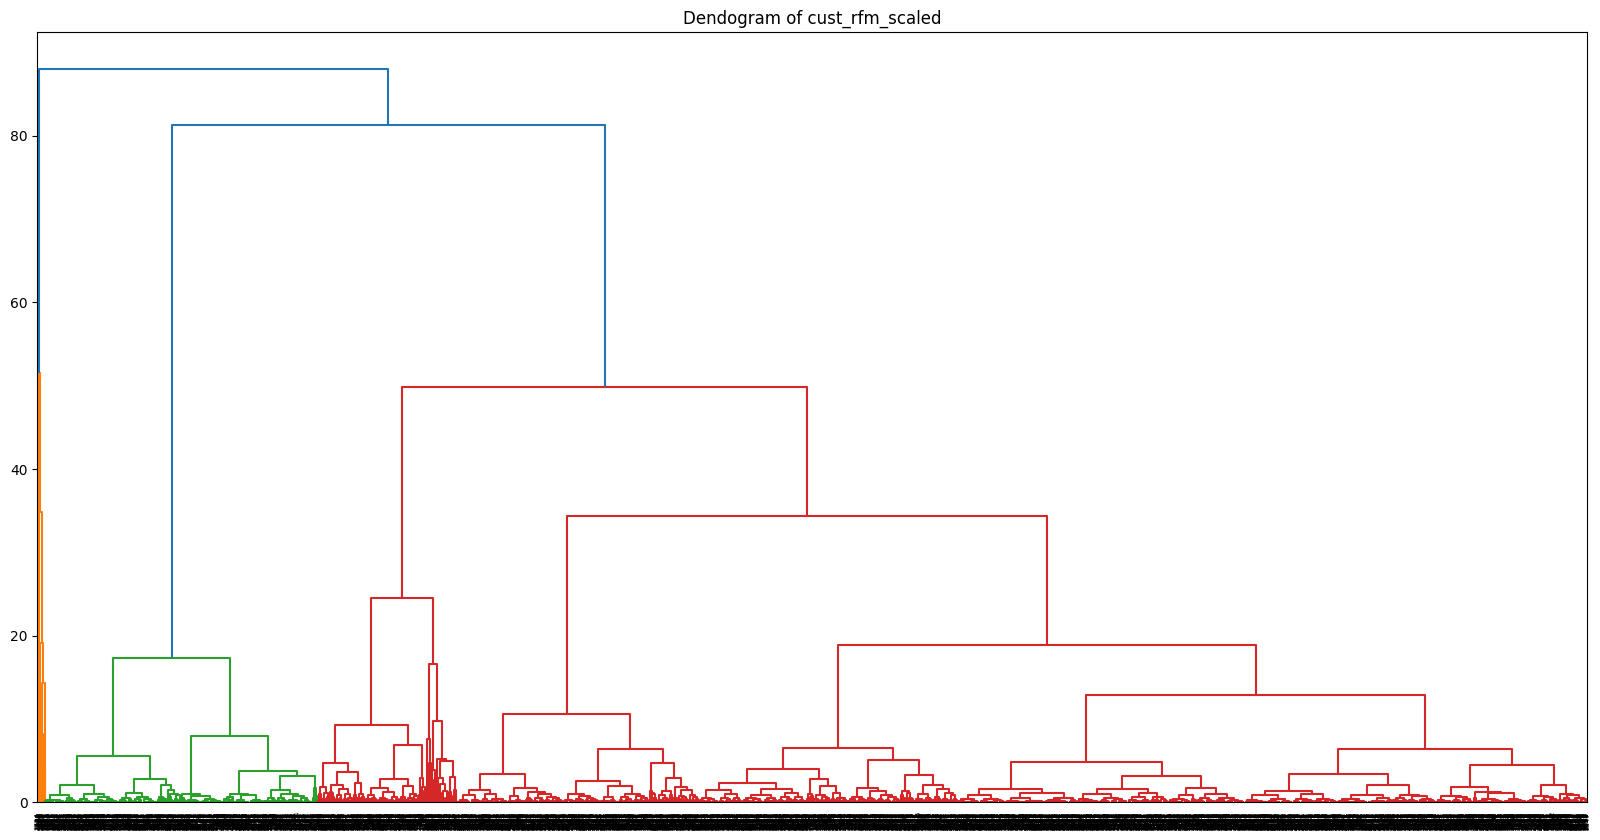

In [82]:
plt.figure(figsize=(20, 10))
plt.title('Dendogram of cust_rfm_scaled')
dend = shc.dendrogram(shc.linkage(cust_rfm_scaled[['Recency_Val_Scaled', 'Frequency_Val_Scaled', 'Monetary_Val_Scaled']], method='ward'))

Note: above Dendrogram took significant runtime to produce, even for only 4,331 customers data.

In a dendrogram, the distance between clusters is given by the vertical lines. If the vertical lines of a connection between two clusters are long, we know that those clusters are very different. On the other hand, if they are very short, then the clusters are relatively similar to each other. We want to pick a level (i.e., draw an imaginary horizontal line) on the dendrogram at a height where the vertical lines start to become very long, meaning that all the clusters below this level are quite different from each other. 

I'm going to proceed with drawing a horizontal line at height 20, below which there are 7 distinct clusters. (Method: Draw a horizontal line at height 20, then count how many vertical lines it intercepts). There is a very tall set of orange lines on the left of the dendogram which are likely those outlier customers who are very distant from each other, but even more distant from any other customer

In [85]:
ac = AgglomerativeClustering(n_clusters=7, linkage='ward').fit(cust_rfm_scaled[['Recency_Val_Scaled', 'Frequency_Val_Scaled', 'Monetary_Val_Scaled']])

<Axes: xlabel='AC_Cluster'>

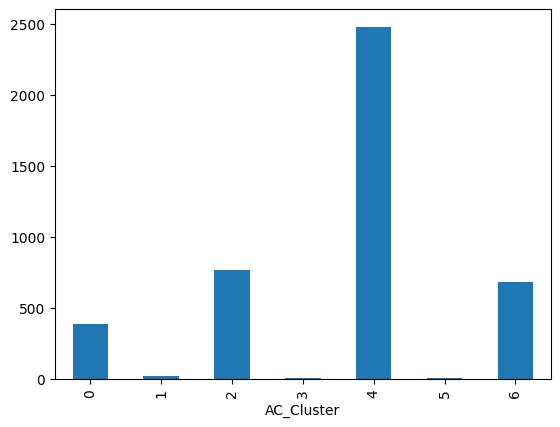

In [86]:
cust_rfm_scaled['AC_Cluster'] = ac.labels_
cust_rfm_scaled['AC_Cluster'].value_counts().sort_index().plot(kind='bar')

In [87]:
cust_rfm_scaled['AC_Cluster'].value_counts().sort_index()

AC_Cluster
0     387
1      16
2     763
3       3
4    2480
5       3
6     679
Name: count, dtype: int64

We see there are 4 clusters with decent size, and 3 clusters that are very small and likely are only containing the outliers. Let's plot the values and see how we can interpret these clusters further in the eyes of an online retail business.

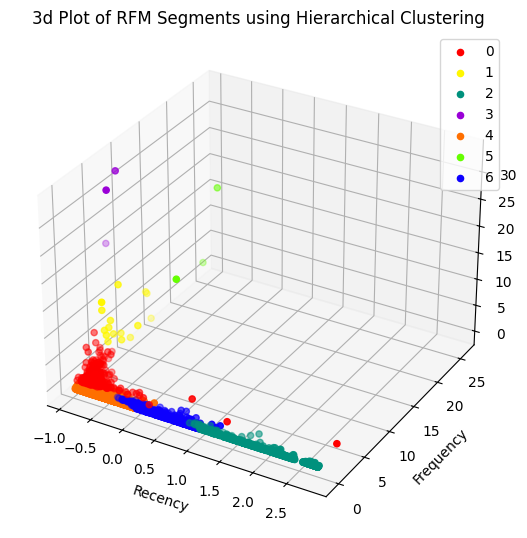

In [88]:
fig = plt.figure()

fig.set_figheight(8)

ax = fig.add_subplot(projection='3d')
ax.set_title('3d Plot of RFM Segments using Hierarchical Clustering')

for i in range(7):
    ax.scatter(cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == i]['Recency_Val_Scaled']
               ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == i]['Frequency_Val_Scaled']
               ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == i]['Monetary_Val_Scaled']
               ,marker='o', color=cm.prism(7*i), label=i)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.legend();

We can see visually that hierarchical clustering has also done a good job separating the datapoints into mostly well-defined groups, and outliers have been put into separate groups away from the other clusters. As with before, I'm going to plot this again without the outlier clusters (1, 3, and 5) to get a more zoomed in picture of the vast majority of the customers.

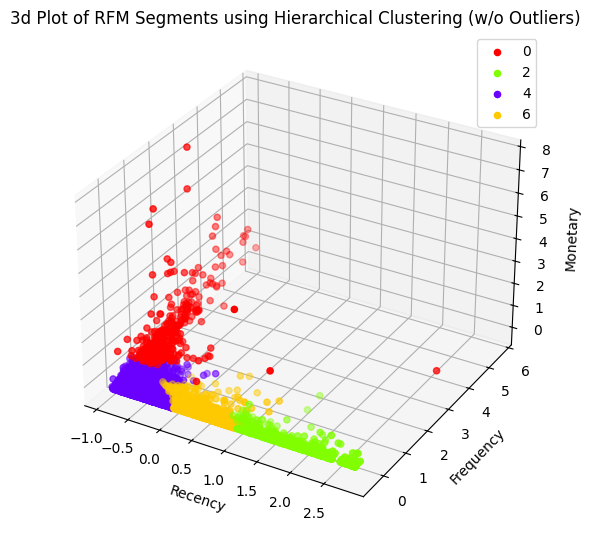

In [101]:
fig = plt.figure()

fig.set_figheight(8)

ax = fig.add_subplot(projection='3d')
ax.set_title('3d Plot of RFM Segments using Hierarchical Clustering (w/o Outliers)')

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == 0]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == 0]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == 0]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(0), label=0)

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == 2]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == 2]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == 2]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(10), label=2)

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == 4]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == 4]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == 4]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(20), label=4)

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == 6]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == 6]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster'] == 6]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(30), label=6)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.legend();

<Axes: title={'center': 'Monetary'}, xlabel='AC_Cluster', ylabel='Monetary_Val_Scaled'>

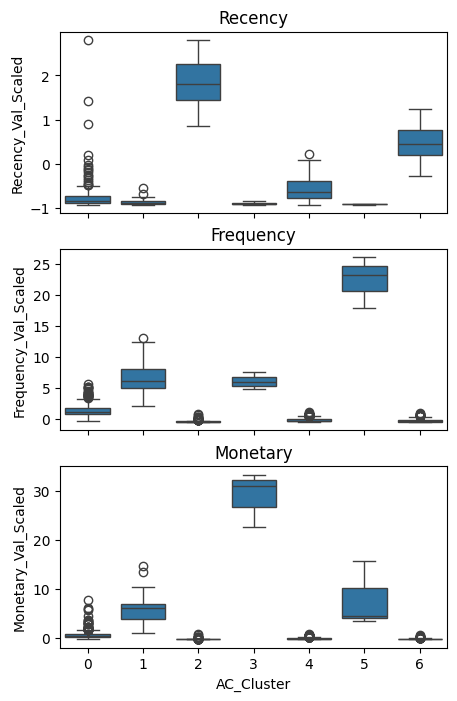

In [92]:
fig, axs = plt.subplots(3, 1, sharex=True)
    
fig.set_figwidth(5)
fig.set_figheight(8)

axs[0].set_title('Recency')
axs[1].set_title('Frequency')
axs[2].set_title('Monetary')

sns.boxplot(x=cust_rfm_scaled['AC_Cluster'], y=cust_rfm_scaled['Recency_Val_Scaled'], ax=axs[0])
sns.boxplot(x=cust_rfm_scaled['AC_Cluster'], y=cust_rfm_scaled['Frequency_Val_Scaled'], ax=axs[1])
sns.boxplot(x=cust_rfm_scaled['AC_Cluster'], y=cust_rfm_scaled['Monetary_Val_Scaled'], ax=axs[2])

Business definitions for the 7 clusters given by agglomerative clustering are below. Because there are fewer clusters involved, I found that what would be previously 2 and 3 star customers are now combined in cluster 0. Also, both Lapsing & Lapsed customers are combined in cluster 2. 

| AC_Cluster | Size | Size% |   Recency   |  Frequency |  Monetary  | Description                        |
|:----------:|:----:|:-----:|:-----------:|:----------:|:----------:|------------------------------------|
|      0     |  387 |   9%  |     Low     | Low/Medium | Low/Medium | Recently Active 2-3* Customers     |
|      1     |  16  |   0%  |     Low     |   Medium   |   Medium   | Outliers (med freq., med monetary) |
|      2     |  763 |  18%  |     High    |     Low    |     Low    | Lapsing & Lapsed Customers         |
|      3     |   3  |   0%  |     Low     |   Medium   |    High    | Outliers (high monetary)           |
|      4     | 2480 |  57%  |     Low     |     Low    |     Low    | Recently Active 1* Customers       |
|      5     |   3  |   0%  |     Low     |    High    |   Medium   | Outliers (high frequency)          |
|      6     |  679 |  16%  | Medium/High |     Low    |     Low    | Inactive Customers                 |


# Model Comparison: Agglomerative clustering with n_clusters=9
As a comparison exercise, I tried agglomerative clustering with n=9, to provide a closer apples-to-apples comparison with what we got from K-means clustering.

<Axes: xlabel='AC_Cluster2'>

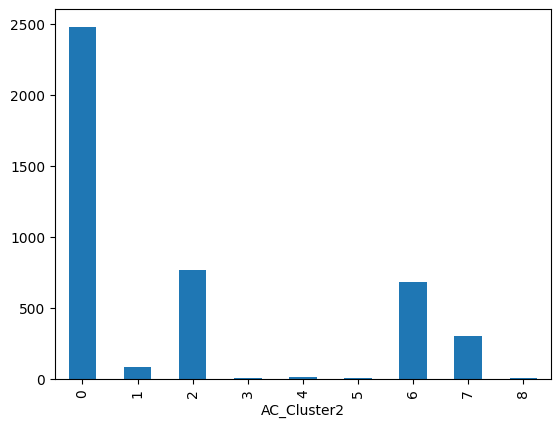

In [94]:
ac2 = AgglomerativeClustering(n_clusters=9).fit(cust_rfm_scaled[['Recency_Val_Scaled', 'Frequency_Val_Scaled', 'Monetary_Val_Scaled']])
cust_rfm_scaled['AC_Cluster2'] = ac2.labels_
cust_rfm_scaled['AC_Cluster2'].value_counts().sort_index().plot(kind='bar')

In [96]:
cust_rfm_scaled['AC_Cluster2'].value_counts().sort_index()

AC_Cluster2
0    2480
1      84
2     763
3       3
4      13
5       3
6     679
7     303
8       3
Name: count, dtype: int64

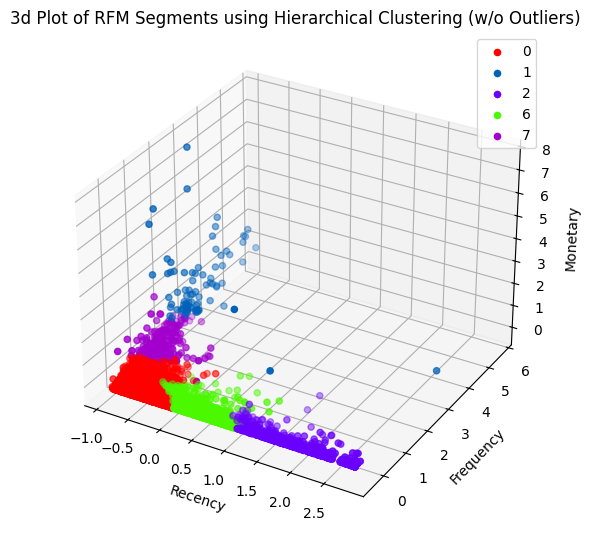

In [102]:
fig = plt.figure()

fig.set_figheight(8)

ax = fig.add_subplot(projection='3d')
ax.set_title('3d Plot of RFM Segments using Hierarchical Clustering (w/o Outliers)')

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 0]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 0]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 0]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(0), label=0)

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 1]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 1]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 1]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(15), label=1)

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 2]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 2]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 2]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(20), label=2)

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 6]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 6]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 6]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(60), label=6)

ax.scatter(cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 7]['Recency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 7]['Frequency_Val_Scaled']
           ,cust_rfm_scaled[cust_rfm_scaled['AC_Cluster2'] == 7]['Monetary_Val_Scaled']
           ,marker='o', color=cm.prism(70), label=7)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.legend();

The first thing to note is that this time, agglomerative clustering gave us 4 outlier segments, while K-Means with the same # of clusters only had 3. This means the agglomerative approach gives us 1 less "useful" cluster based on the data.

We can see that take effect when we plot the non-outlier clusters in the 3d plot. For the most recent customers, we see it's divided into what I called 1-star, 2-star, and 3-star customers but the 1-star range of values for frequency and monetary are larger. As a result, cluster 0 above has 2,480 members while the equivalent cluster from K-Means only had 1,599. Also, cluster 1 above only has 84 members while the equivalent cluster from K-Means had 112. I find that the 1/2/3 star customers were distributed slightly better using K-Means.

In terms of recency, there are 3 clear clusters (#0, #2, #6) for Recently Active, Inactive, and Lapsing/Lapsed customers respectively. Using K-Means, we had 4 groups: Recently Active, Inactive, Almost Lapsed, and Lapsed customers. Again, I find K-Means gave a better distribution of customers because it was able to produce 4 clusters with different recency ranges instead of just 3.

# Conclusion: Which model is best?

In this project we've explored performing RFM segmentation using an approach with quartiles, an approach using K-Means clustering, and with Hierarchical (agglomerative) clustering. There are definite pros & cons to each method.

The non-clustering approach using quartiles is easy to explain to business decision makers, and can produce good results but requires many steps and tweaking of the methodology to make the resulting segments make sense. Even from that point, it requires more work to group segments together into clear, well-defined, and marketable customer groups. It's clear the clustering eliminates the need for this sort of 'post-processing', because the grouping is done natively in the algorithm itself (clustering!). This is the main draw I feel for clustering over a non-clustering method of RFM.

As for clustering methods, both K-Means and Agglomerative produced clear and well-defined clusters. For K-Means, the ideal number of clusters was 9 while for Agglomerative, the ideal given by the dendrogram was n_clusters=7. However, I found 7 to be too small from a business perspective. It resulted in clusters that had wider-than-ideal value ranges, and one cluster contained over half of the total customer base. With 9 clusters under K-Means, the largest cluster was only 37% of customers which means customers were distributed more evenly. For this reason, I felt that the 9 clusters resulted in better defined segments that are more likely to contain similar-minded customers.

When using n_clusters=9, K-Means produced 6 "useable" clusters with significant # of customers, while Agglomerative only produced 5 because there was one additional outlier cluster that we couldn't really use. As a result, I found that K-Means yielded a higher quality segmentation; the value ranges for each cluster were tighter than for Agglomerative. For a business, that will be useful because customers that fit into a tighter value range are more similar and easier to create a unified marketing strategy for.

In hindsight, I could have gotten better results with both clustering algorithms by removing outlier datapoints (i.e., customers with very high frequency and/or monetary) from the dataset before clustering. However, it was useful to see how the outliers affected both algorithms. In this case, it looks like agglomerative did not handle it as well as it produced 4 "outlier" clusters, while K-means only produced 3 using the same number of total clusters. As a result, overall the K-Means approach yielded better customer segments for this exercise.

# References <a name="ref"></a>
$^{1}$Online Retail. UCI Machine Learning Repository. (n.d.). https://archive.ics.uci.edu/dataset/352/online+retail<br>
$^{2}$Pandas binning function. Pandas Documentation. https://pandas.pydata.org/docs/reference/api/pandas.cut.html<br>
$^{3}$SKLearn AgglomerativeClustering. Scikit-Learn Documentation. https://scikit-learn.org/dev/modules/generated/sklearn.cluster.AgglomerativeClustering.html